In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import json

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.losses import loss_peak_mse
from src.ForecastModel.utils.postprocessing import ModelHandler

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 6,
})

In [2]:
PLOT_PATH          = r"plots"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [3]:
model_handle =  ModelHandler("PBHM-HLSTM",
                           r"rst\PBHM-HLSTM",
                           is_final_model = True,
                           color = "#e41a1c",
                           ls = "-",
                          )

## load model and data

In [4]:
# initalize
m  = 50 # number of lamellas to approximate integral, m=200 for results - m=1 for testing
num_hindcast_feat = len(model_handle.feat_hindcast)
num_forecast_feat = len(model_handle.feat_forecast)

# load datamodel
dm = DataModelCV(DATA_PATH,
       target_name       = model_handle.target_name,
       hincast_features  = model_handle.feat_hindcast,
       forecast_features = model_handle.feat_forecast,
     )

# load trial data
with open(os.path.join(model_handle.hp_path, "trial.json")) as f:
    trial = json.load(f)

hindcast_length = trial['hyperparameters']['values']['hindcast_length']
forecast_length = 96

dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))

all_intgrad_0 = np.zeros((5, hindcast_length, num_hindcast_feat))
all_intgrad_1 = np.zeros((5, forecast_length, num_forecast_feat))

# load model of fold 5 (final model)
tf.keras.backend.clear_session()
keras_save_file_path = os.path.join(model_handle.hp_path, f"model_fold_{4:d}.keras")
model  = tf.keras.models.load_model(keras_save_file_path)

df = pd.DataFrame()
for n_fold in range(5):
    print(f"processing fold {n_fold}")
    # load dataset
    X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

    # get baseline input
    X_base = tf.zeros_like(X[0])
    num_samples = y.shape[0]
    batch_size  = 2000
    num_of_batches = num_samples//batch_size + 1

    for batch_num in range(num_of_batches):
        print(f"{batch_num+1} / {num_of_batches}", end="\r")
        
        X_tensor_0 = tf.convert_to_tensor(X[0][batch_num*batch_size:(batch_num+1)*batch_size,:,:], dtype=tf.float32)
        X_tensor_1 = tf.convert_to_tensor(X[1][batch_num*batch_size:(batch_num+1)*batch_size,:,:], dtype=tf.float32)
        
        
        base_tensor_0 = tf.zeros_like(X_tensor_0)
        base_tensor_1 = tf.zeros_like(X_tensor_1)
        
        offset_tensor_0 = (X_tensor_0 - base_tensor_0) / tf.constant(m, dtype=tf.float32)
        offset_tensor_1 = (X_tensor_1 - base_tensor_1) / tf.constant(m, dtype=tf.float32)
        
        for k in range(1, m+1):
            inp_tensor_0 = X_tensor_0 + tf.constant(k, dtype=tf.float32) * offset_tensor_0
            inp_tensor_1 = X_tensor_1 + tf.constant(k, dtype=tf.float32) * offset_tensor_1
            inp_tensor_list = [inp_tensor_0 , inp_tensor_1]
        
            with tf.GradientTape() as t:
                t.watch(inp_tensor_0)
                t.watch(inp_tensor_1)
                output = tf.math.reduce_sum(model(inp_tensor_list), axis=1) # analysis sum of model output 
            
            grad_0, grad_1 = t.gradient(output, inp_tensor_list)
            
            if k == 1:
                total_grad_0 = grad_0
                total_grad_1 = grad_1
            else:
                total_grad_0 += grad_0
                total_grad_1 += grad_1
        
        # integrated gradients of size (batch_size, num_of_nodes, num_of_features)
        integrated_grad_0 = offset_tensor_0 * total_grad_0
        integrated_grad_1 = offset_tensor_1 * total_grad_1

        # sumed over batch and divided by number of all samples to get the mean value over all samples
        all_intgrad_0[n_fold,:,:] += np.sum(np.abs(integrated_grad_0), axis=0) / num_samples
        all_intgrad_1[n_fold,:,:] += np.sum(np.abs(integrated_grad_1), axis=0) / num_samples


    # mean over the hindcast/forecast input steps
    df.loc[n_fold, ["h_" + x for x in model_handle.feat_hindcast]] = np.sum(all_intgrad_0[n_fold,:,:], axis=0) / hindcast_length
    df.loc[n_fold, ["f_" + x for x in model_handle.feat_forecast]] = np.sum(all_intgrad_1[n_fold,:,:], axis=0) / forecast_length


dictonary loaded
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4


In [5]:
# save results
np.save(r"rst\ig_hindcasts-all_folds-final_model.npy", all_intgrad_0)
np.save(r"rst\ig_forecasts-all_folds-final_model.npy", all_intgrad_1)
df.to_pickle(r"rst\ig_all_folds-final_model.pkl")

all_intgrad_0 = np.load(r"rst\ig_hindcasts-all_folds-final_model.npy")
all_intgrad_1 = np.load(r"rst\ig_forecasts-all_folds-final_model.npy")
df = pd.read_pickle(r"rst\ig_all_folds-final_model.pkl")


## summary of hindcast features - all samples for all folds

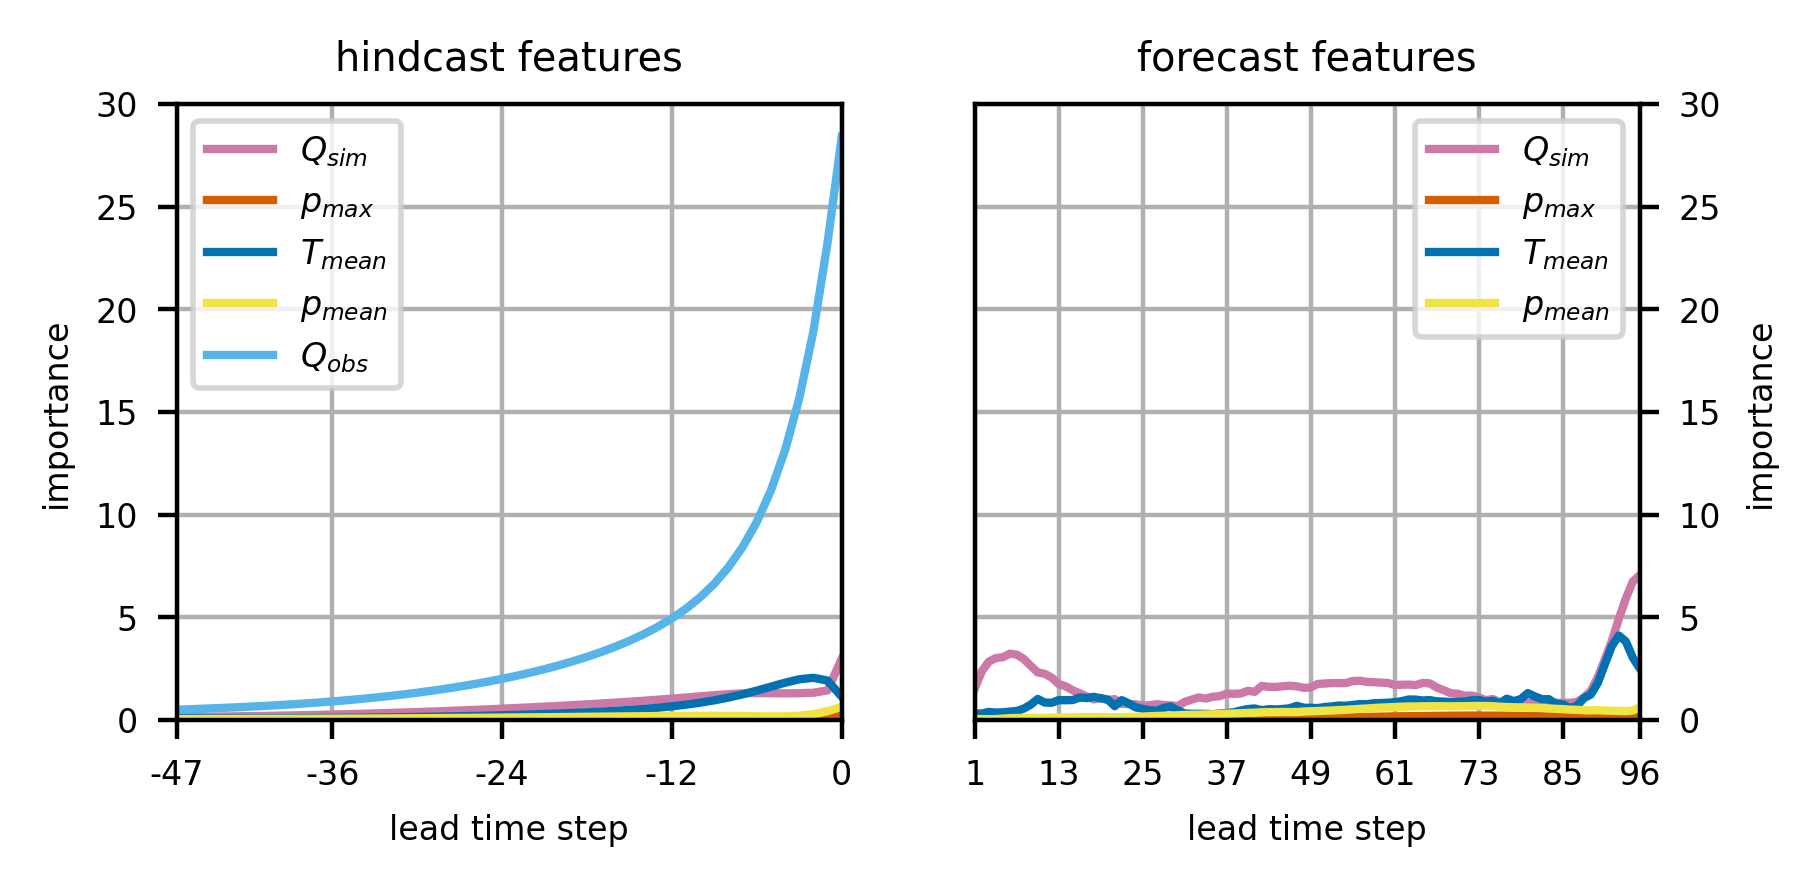

In [6]:
colors = ["#CC79A7", "#D55E00", "#0072B2", "#F0E442", "#56B4E9"]
feat_names = [r"$Q_{sim}$", r"$p_{max}$", r"$T_{mean}$", r"$p_{mean}$", r"$Q_{obs}$"]

fig,axes = plt.subplots(1,2, figsize=(4.72,2), dpi=400)

for n in range(all_intgrad_0.shape[2]):
    # sum over folds
   axes[0].plot(np.sum(all_intgrad_0[:,:,n], axis=0), c=colors[n], label=feat_names[n])

    
axes[0].set_title("hindcast features")
axes[0].set_xlabel("lead time step")
axes[0].set_ylabel("importance")
axes[0].set_xticks([0] + [x for x in range(11,98,12)])
axes[0].set_xticklabels([f"{int(x-hindcast_length+1):d}" for x in axes[0].get_xticks()])
axes[0].set_xlim([0,hindcast_length-1])
axes[0].set_ylim([0,30])
axes[0].legend()
axes[0].grid()


for n in range(all_intgrad_1.shape[2]):
    # sum over folds
    axes[1].plot(np.sum(all_intgrad_1[:,:,n], axis=0), c=colors[n], label=feat_names[n])
    
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set_title("forecast features")
axes[1].set_xlabel("lead time step")
axes[1].set_ylabel("importance")
axes[1].set_xticks([0] + [x for x in range(11,98,12)])
axes[1].set_xticklabels([f"{int(forecast_length-x):d}" for x in axes[1].get_xticks()])
axes[1].set_xlim([95,0])
axes[1].set_ylim([0,30])
axes[1].legend()
axes[1].grid()


In [9]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, "figX-ig_all_samples-all_folds.png"), bbox_inches="tight")

In [10]:
df

,h_qsim,h_pmax,h_tmean,h_pmean,h_qmeasval,f_qsim,f_pmax,f_tmean,f_pmean
0,0.228674,0.011424,0.085877,0.037594,1.453553,0.511539,0.025576,0.209917,0.101860
1,0.193039,0.013260,0.097522,0.039447,1.358196,0.451064,0.028118,0.205467,0.099802
2,0.096454,0.006125,0.095311,0.016616,0.636933,0.201409,0.011651,0.155301,0.040527
3,0.117850,0.011192,0.110402,0.027222,0.777026,0.282603,0.021748,0.164912,0.069858
4,0.061720,0.005205,0.120817,0.013451,0.334859,0.245553,0.022355,0.161654,0.070133
